Comparing methods for dynamic functional connectivity in brain imaging
--
This notebook implements the first few analysis steps required for dynamic connectivity analysis based on sliding-windows

Step 1 -- Open time series

Scan the directory and read time series 

In [1]:
import numpy as np 

In [2]:
import os 
datapath = '/Users/nicolasfarrugia/Documents/recherche/data_mpilmbb/'
fileslist = os.listdir(os.path.join(datapath,'10subjects')) 

Print the list of files 

In [3]:
fileslist

['subj_010001_ses-02_task-rest_acq-AP_run-01_M_BASC_scale064.npz',
 'subj_010001_ses-02_task-rest_acq-AP_run-02_M_BASC_scale064.npz',
 'subj_010001_ses-02_task-rest_acq-PA_run-01_M_BASC_scale064.npz',
 'subj_010001_ses-02_task-rest_acq-PA_run-02_M_BASC_scale064.npz',
 'subj_010002_ses-02_task-rest_acq-AP_run-01_M_BASC_scale064.npz',
 'subj_010002_ses-02_task-rest_acq-AP_run-02_M_BASC_scale064.npz',
 'subj_010002_ses-02_task-rest_acq-PA_run-01_M_BASC_scale064.npz',
 'subj_010002_ses-02_task-rest_acq-PA_run-02_M_BASC_scale064.npz',
 'subj_010004_ses-02_task-rest_acq-AP_run-01_M_BASC_scale064.npz',
 'subj_010004_ses-02_task-rest_acq-AP_run-02_M_BASC_scale064.npz',
 'subj_010004_ses-02_task-rest_acq-PA_run-01_M_BASC_scale064.npz',
 'subj_010004_ses-02_task-rest_acq-PA_run-02_M_BASC_scale064.npz',
 'subj_010005_ses-02_task-rest_acq-AP_run-01_M_BASC_scale064.npz',
 'subj_010005_ses-02_task-rest_acq-AP_run-02_M_BASC_scale064.npz',
 'subj_010005_ses-02_task-rest_acq-PA_run-01_M_BASC_scale064.n

Open each file (each file has a time series and an id) and store them in lists 

In [4]:
allts = []
allid = []

for curfile in fileslist:
    allts.append(np.load(os.path.join(datapath,'10subjects',curfile))['ts'])
    allid.append(np.load(os.path.join(datapath,'10subjects',curfile))['id'])

Turn the list into a numpy array, and print the shape of the resulting array 

In [5]:
allts = np.stack(allts)
print(allts.shape)

(40, 652, 93)


40 files, 652 volumes, 93 ROIs

Let's print some time series, just for fun 

In [6]:
from matplotlib import pyplot as plt 

%matplotlib inline

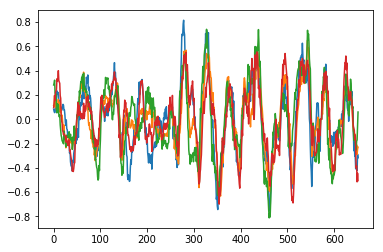

In [7]:
subject = 12
plt.plot(allts[subject,:,3:7]) ## rois 3 to 7 

Let's compute Static connectivity (on the whole time series)

In [8]:
from nilearn.connectome import ConnectivityMeasure
estimator = ConnectivityMeasure(kind='correlation',vectorize=False,discard_diagonal=True)

static_FC = estimator.fit_transform(allts)

In [9]:
print(static_FC.shape)

(40, 93, 93)


This is 40 subjects, 93 regions x 93 regions. 

Let's plot one of these static FC matrices

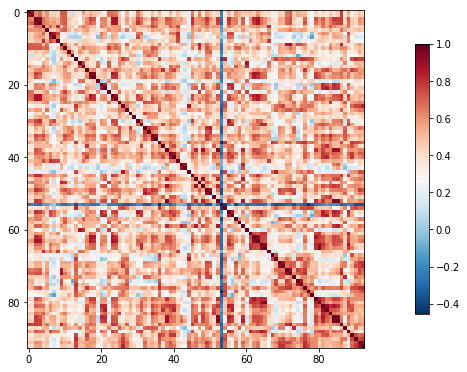

In [10]:
from nilearn.plotting import plot_matrix, plot_connectome

plot_matrix(static_FC[30])

Let's visualize it with the ROI locations. 
Load the atlas 

Atlas has 93 rois 


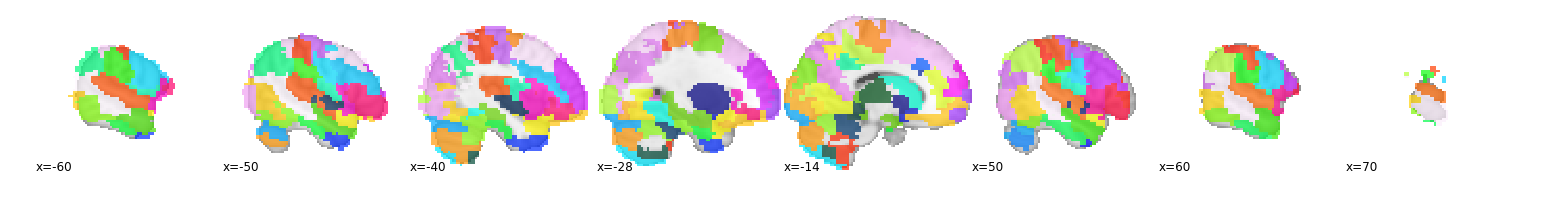

In [11]:
# Current ATLAS  
roi_maps = 'basc_2mm_scale064.nii.gz'

from nilearn.plotting import plot_prob_atlas,plot_roi
from nilearn.regions import connected_label_regions

labels_maps = connected_label_regions(roi_maps)
plot_roi(labels_maps,cut_coords=8,display_mode='x')

nrois = np.unique(labels_maps.get_data())[-1]
print("Atlas has %d rois " % nrois)

The following cell extracts the baricenters of the regions and creates a 3 x 93 arrays of ROI center coordinates 

In [12]:
from nilearn.image import math_img
from nilearn.image import iter_img

from nilearn.plotting import find_xyz_cut_coords


roi_maps_4D = []

for i in range(1,nrois+1):
    curimg = math_img('img == %d' % i ,img=labels_maps)
    roi_maps_4D.append(curimg)
    

coords_connectome = [find_xyz_cut_coords(img) for img in iter_img(roi_maps_4D)]
coords_connectome = np.stack(coords_connectome)

print(coords_connectome.shape)

(93, 3)


Now let's plot a few connectomes from a bunch of subjects 

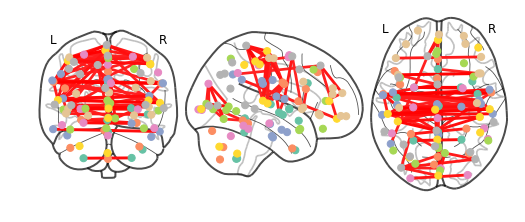

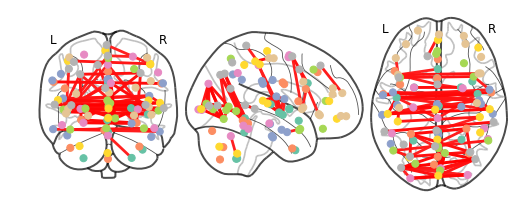

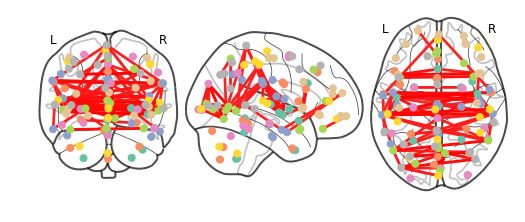

In [13]:
from nilearn.plotting import plot_connectome 

n_subj_to_plot = 3

for i in np.random.choice((static_FC.shape[0]),n_subj_to_plot):

    curA = (static_FC[i])
    plot_connectome(curA,coords_connectome,edge_threshold='98.5%')
    plt.show()

Step 2 - Sliding windows

The function dfc_slid_window implements the following :
- cutting the data in sliding windows of length ws, sliding by steps of ss
- Applies a Tucker window for tapering (to smooth edge effects) 

It expect an input in the form [subjects,volumes,regions], so if you want to calculate sliding windows on a single subjects, reshape it to [1,volumes,regions] using np.reshape

Let's check its syntax

In [14]:
from dfc import dfc_slid_window
dfc_slid_window?

Calculate sliding windows 

In [15]:
all_sl,_ = dfc_slid_window(allts,15)

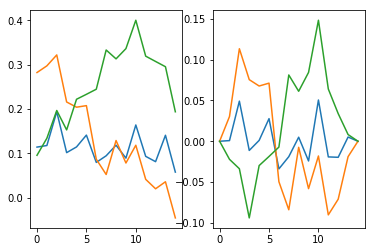

In [16]:
subject = 12
roi = 7

plt.subplot(1,2,1)
plt.plot(allts[subject,:15,4:7])

plt.subplot(1,2,2)
plt.plot(all_sl[subject,0,:,4:7])

In [17]:
print(all_sl.shape)

(40, 637, 15, 93)


this corresponds to (subjects, number of sliding windows, window size, regions )

Computing FC matrices for all windows

In [18]:
from nilearn.connectome import ConnectivityMeasure
estimator = ConnectivityMeasure(kind='correlation',vectorize=False,discard_diagonal=True)

all_FC_sl = []

for sl in all_sl:
    all_FC_sl.append(estimator.fit_transform(sl))
    
    
all_FC_sl = np.stack(all_FC_sl)

the resulting shape are FC matrices:  (subjects, number of sliding windows, regions, regions) 

In [19]:
all_FC_sl.shape

(40, 637, 93, 93)

Plot one of the FC matrices

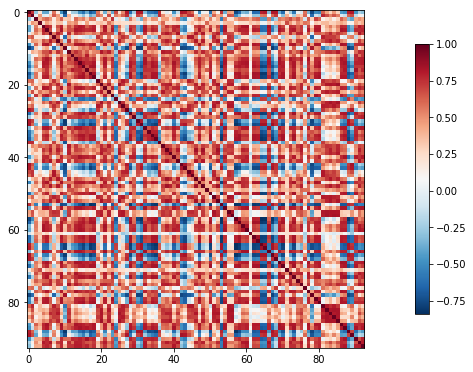

In [20]:
from nilearn.plotting import plot_matrix
subject = 13
timewindow = 27

plot_matrix(all_FC_sl[subject,timewindow])

In [21]:
plot_matrix?

Object `plot_matrixix` not found.


Calculate similarity across the temporal dimension 

recomputing connectivity with option "vectorize = True" so that FC matrices are put in the vector form. This makes more sense to calculate similarity between FC as a function of time. 

In [22]:
from nilearn.connectome import ConnectivityMeasure
estimator = ConnectivityMeasure(kind='covariance',vectorize=True,discard_diagonal=True)

all_FC_sl = []

for sl in all_sl:
    all_FC_sl.append(estimator.fit_transform(sl))
    
    
all_FC_sl = np.stack(all_FC_sl)

go through all subjects

In [23]:
all_FC_sl.shape

(40, 637, 4278)

Compute Cosine Similarity between FC 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

all_cosine_sim = []
for i,slFC in enumerate(all_FC_sl): # subjects
    #windows
    cur_sim = cosine_similarity(slFC)
    all_cosine_sim.append(cur_sim)
    plt.imshow(cur_sim,cmap=plt.cm.hot)
    plt.title(allid[i])
    plt.colorbar()
    plt.show()
    
all_cosine_sim = np.stack(all_cosine_sim)

These matrices correspond to the similarity of sliding-window connectivity as a function of time.

Save the results 

In [ ]:
np.savez_compressed(os.path.join(datapath,'FC_variability.npz'),all_cosine_sim=all_cosine_sim,ids=allid)

warning - the next cell writes a file that takes 834 Mo (for ws = 15)

In [24]:
np.savez_compressed(os.path.join(datapath,'FC_matrices.npz'),FCmatrices=all_FC_sl,ids=allid)

Next steps from here 
--

- To perform K-means clustering on the FC matrices, use sklearn MinibatchKMeans() on all_FC_sl. For visualization, average all FC matrices with the same labels
- Spectral Clustering or DBScan can be performed by inputting the similarity maps (all_cosine_sim), and use the SpectralClustering or DBScan estimators from sklearn 
- BCT can be used to investigate time-varying graph theory metrics starting from the all_FC_sl matrices
- HMM using hmmlearn https://github.com/hmmlearn/hmmlearn , directly on the time-series (allts)
- A notebook visulazing and comparing the outputs of different methods 